「敵対的サンプル（adversarial examples）の生成 」
======

【原題】ADVERSARIAL EXAMPLE GENERATION

【原著】[Nathan Inkawhich](https://github.com/inkawhich)

【元URL】https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　御手洗 拓真

【日付】2020年11月23日

【チュトーリアル概要】

機械学習モデルに対する攻撃手法である「敵対的サンプル（adversarial examples）」について解説し、実際に攻撃を実装士ながら学びます。

---


はじめに
----------

本チュートリアルまで進んだ方であれば、すでに機械学習モデルがどれほど有効な手段であるかを理解いただけていると思います。

研究者らによって機械学習モデルは、より速く、より正確に、そしてより効率的になるように、改善され続けています。

一方で機械学習モデルを設計したり訓練したりする際に、見落とされがちな側面もあります。

それは特に、モデルを騙そうとする敵対者（攻撃者）に直面した場面における、モデルの安全性と堅牢性です。


本チュートリアルでは、機械学習モデルにおけるセキュリティ上の脆弱性に関する認識を深めていただくよう、昨今話題の敵対的機械学習（adversarial machine learning）に関して解説します。


人間には認識できない程度のノイズを画像に加えることで、モデルの性能が劇的に変わってしまうことに驚くかもしれません。

本チュートリアルでは画像分類モデルを例に、本トピックについて掘り下げていきます。

具体的には、最も初期に発表され、また最も認知されている攻撃手法の一つである「高速勾配符号攻撃（FGSM：the Fast Gradient Sign Attack）」を用いて、MNISTのモデルを騙してみます。

モデルへの脅威 
----------

機械学習モデルに対する攻撃には、多くのカテゴリーがあります。

攻撃者がモデルに対して保有している前提知識や、攻撃目的によって、攻撃のカテゴリーは分類されます。

ですが一般的には、入力データに最小限のノイズを加え、攻撃者が目的とする誤分類を引き起こすことが共通の目標となります。



攻撃者がモデルに対して持っている前提知識に関する仮定にはいくつかの種類があります。

代表的な前提の置き方は、**ホワイトボックス**と**ブラックボックス**です。

**ホワイトボックス** 攻撃は、攻撃者がモデルのアーキテクチャ、入力、出力、重みといった、モデルに関する完全な知識とアクセス権を持っていると仮定します。

**ブラックボックス**攻撃では、攻撃者はモデルの入力と出力にしかアクセスできず、基礎となっているモデルアーキテクチャや重みについては何も知らないと仮定します。




また、攻撃の目的としては、**誤分類**や、**ソース/ターゲットの誤分類**など、いくつかのタイプがあります。

**誤分類**は、敵対者は出力の分類が間違っていることを望んでいるだけで、新しい分類が何であるかは気にしていないケースです。

**ソース/ターゲットの誤分類**では、敵対者は、ある特定の元のクラス（ソースクラス）の画像を、ある特定の別のクラス（ターゲットクラス）に分類されるように変更したいと考えています。



上記を踏まえると、FGSM攻撃は**誤分類**を目的とした**ホワイトボックス**攻撃となります。

上記の背景を踏まえたうえで、攻撃手法の詳細について説明します。

Fast Gradient Sign Attack（高速勾配符号攻撃）
----------------

今日までに発見された攻撃手法のうち、最も初期に提案され、かつ最もポピュラーな攻撃方法の一つは、*Fast Gradient Sign Attack：（FGSM）*と呼ばれています。

この攻撃手法については、Goodfellowらによって、[Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)で詳細に説明されています。

この攻撃は驚くほど強力であると同時に、直感的に理解しやすい内容です。

ニューラルネットワークが学習する手段である「*勾配*」を利用し、ネットワークを攻撃するように設計されています。



考え方はシンプルです。

通常の学習では逆伝播された勾配に基づいて

「損失を**最小化**するように**重み**を調整」しますが、

この攻撃では、同じく逆伝播された勾配に基づいて「損失を**最大化**するように**入力データ**を調整」するのです。

<br>

コードの実装に移る前に、[`FGSM`]( https://arxiv.org/abs/1412.6572)で発表された有名なパンダの画像と、簡単な数式を掲載します。

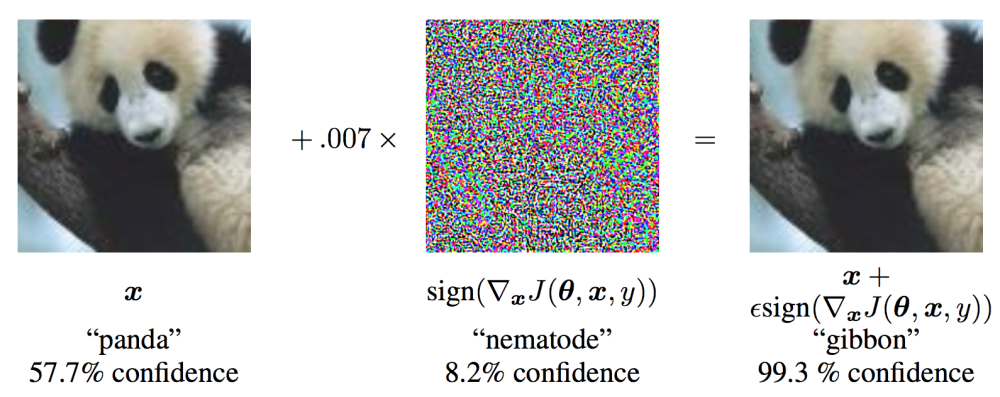

上図における$\mathbf{x}$は正しく「パンダ」として分類された元の入力画像を意味しています。

$y$は、$\mathbf{x}$の正解ラベルです。

$\mathbf{\theta}$はモデルのパラメータを表しています。

$J(\mathbf{\theta},\mathbf{x},y)$はネットワークの学習に使用される損失です。

攻撃時には、$\nabla_{x}J(\mathbf{\theta},\mathbf{x},y)$を計算するために、勾配を入力データまで逆伝播させます。

そして、損失が最大になる方向（例：$sign(\nabla_{x}J(\mathbf{\theta},\mathbf{x},y))$）に少しずつ（$\epsilon$または$0.007$ずつ）ノイズを加えて、入力画像の画素値を調整していきます。

結果として得られるノイズが乗った画像$x\prime$は、明らかに「パンダ」であるにもかかわらず、攻撃されているネットワークは「テナガザル」として*誤分類してしまいます*。



上記の説明で、本チュートリアルを行うことの大切さ、意義を明確に感じていただけたかと思います。

実装に挑戦してみましょう。

実装
----------

これからのセクションでは、以下に示す内容を実施します。

- チュートリアルの入力パラメータについての説明
- 攻撃対象のモデルの定義
- 攻撃のコーディング
- テストの実行

### 入力 

本チュートリアルの入力は3変数だけです。以下のように定義されています。

-   **epsilons** -
    実行時に使用するε（イプシロン）のリストです。様々なεで性能を確認します。
    このリストに0を入れておくことは重要です。
というのも、この「0」は、オリジナルのテスト用データセットを使った場合のモデル性能を表しているためです（日本語訳注：εの大きさは加えるノイズの大きさを表します。そのため、ε=0はノイズが加えられていない元のデータを意味します）。
    
    また直感的には、εが大きいほど、ノイズの存在に人が気付きやすくなりますが、一方で攻撃はより効果的になる（≒よりモデルの精度を低下させる）と考えられます。
    なお、今回のモデルの入力データ範囲は\[0, 1]なので、εの値が1を超えてはいけません。
    
-   **pretrained\_model** -
    [`pytorch/examples/mnist`](https://github.com/pytorch/examples/tree/master/mnist)で学習した事前学習済みMNISTモデルへのパスです。
    作業を省略するために、事前学習済みモデルを[**`ここから`**](https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing)ダウンロードしておいてください。

-   **use\_cuda** - 
    CUDAが利用可能な状況でそれを利用したい場合に、CUDAの利用フラグを設定するブール値です。
    なお、本チュートリアルはCPUでもあまり時間はかからないので、CUDAを搭載したGPU利用は必須ではない点に注意してください。

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]  # リストepsilonsについては、後ほど詳しく解説します
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

In [3]:
# 日本語訳注：ダウンロードしたファイル「lenet_mnist_model.pth」を
# Google Colaboratory上にアップロードして使用します
from google.colab import files

uploaded = files.upload()
# lenet_mnist_model.pthを選んでください

Saving lenet_mnist_model.pth to lenet_mnist_model.pth


In [4]:
# 日本語訳注：ダウンロードしたファイル「lenet_mnist_model.pth」を
# Google Colaboratory上にアップロードして使用します
pretrained_model = "lenet_mnist_model.pth"

### 攻撃対象のモデル

前述の通り、攻撃対象のモデルは[`pytorch/examples/mnist`](https://github.com/pytorch/examples/tree/master/mnist)のMNISTモデルと同じです。

ここで使うモデルは、自分で訓練して保存したMNISTモデルでも、提供されている訓練済みモデルをダウンロードしたものでも大丈夫です。

以下に掲載しているスクリプトでの`Net`の定義と`test_loader`は、MNISTの例からコピーしたものです。

このセクションの目的は、モデルとデータローダーの定義をすること、モデルを初期化すること、訓練済みの重みをロードすることになります。

In [5]:
# LeNet Model 定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNISTのTest datasetと dataloaderの定義
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)

# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


CUDA Available:  True




Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### FGSMによる攻撃

ここでは、元の入力データにノイズを足して敵対的サンプルを作成する関数を定義します。

`fgsm_attack `関数には、以下の3 つの入力が必要です。

- `image `: ノイズが加えられる前の元の画像($x$)です。
- `epsilon` : ピクセル単位のノイズの大きさ($\epsilon$)です。
- `data_grad` : 入力画像に対する損失の勾配($\nabla_{x}J(\mathbf{\theta},\mathbf{x},y)$)です。

この`fgsm_attack `関数は、以下に掲載した数式のようにノイズが追加された画像を返します。

<br>

$perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇xJ(θ,x,y))$

<br>

最後に、元々のデータの範囲を維持するために、ノイズを追加した画像を[$0,1\rbrack$の範囲となるようにクリッピングします。

In [6]:
# FGSM による攻撃用のコード
def fgsm_attack(image, epsilon, data_grad):
    # データの勾配の各要素のsign値を取得します
    sign_data_grad = data_grad.sign()
    # 入力画像の各ピクセルを調整して、ノイズが追加された画像を作成します
    perturbed_image = image + epsilon*sign_data_grad
    # [0,1]の範囲になるようデータをクリップします
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # ノイズが追加された画像を返します
    return perturbed_image

### テスト用の関数

最終的に、本チュートリアルの主な結果を、`test`関数から取得できるようにします。

この関数を実行すると、MNISTのテスト用データセットに対して一連のテスト処理を行い、最終的な精度を出力します。

ここで、この`test`関数は入力引数として、`epsilon`を受け取る点に注意してください。

この引数$\epsilon$は、$\epsilon$という強さの攻撃を受けた場合のモデルの精度を`test`関数が算出するように設定します。



もう少し具体的に`test`関数内の処理を解説します。

`test`関数は入力データに対する損失の勾配（`data_grad`）を計算し、次に`fgsm_attack `関数を用いてノイズが加えられた画像(`perturbed_ data`)を作成します。

そして最後に、このノイズ付き画像が敵対的なものかかどうか（日本語訳注：誤分類を招くものかどうか）を確認します。

<br>

この関数はモデルの精度をテストするだけでなく、誤分類させることに成功した敵対的なサンプル（日本語訳注：ノイズが加えられた画像）を保存して返し、後で可視化することもできます。

In [7]:
def test( model, device, test_loader, epsilon ):

    # 精度カウンター
    correct = 0
    adv_examples = []

    # テスト用データセット内の全てのサンプルをループします
    for data, target in test_loader:

        # データとラベルをデバイス（CPUもしくはGPU）に送信します
        data, target = data.to(device), target.to(device)

        # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。
        data.requires_grad = True

        # データをモデルに順伝播させます
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

        # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
        if init_pred.item() != target.item():
            continue

        # 損失を計算します
        loss = F.nll_loss(output, target)

        # 既存の勾配を全てゼロにします
        model.zero_grad()

        # 逆伝播させてモデルの勾配を計算します
        loss.backward()

        # データの勾配を取得します
        data_grad = data.grad.data

        # FGSMによる攻撃の関数を呼び出します
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # ノイズ付き画像を再度分類します
        output = model(perturbed_data)

        # 攻撃の成功を確認します
        final_pred = output.max(1, keepdim=True)[1] # log-probabilityが最大のインデックスを取得します
        if final_pred.item() == target.item():
            correct += 1
            # epsilonが0の場合という特殊なケースを保存
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # あとで可視化するために敵対的サンプルのうちいくつかを保存
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # epsilonごとの最終的な精度を算出
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 精度と敵対的サンプルを返却
    return final_acc, adv_examples

### 攻撃を実行

実装の最後の部分では、実際に攻撃を行います。

ここでは、`epslicons`をイテレートして得られる各$\epsilon$ごとに（＝要素$\epsilon$の値ごとにループさせて）、`test`関数を実行して一連のテスト処理を全て行います。

（epsilons = [0, .05, .1, .15, .2, .25, .3]　と冒頭で定義しています）

<br>

各$\epsilon$の値ごとに、最終的な精度と、誤分類させることに成功した敵対的なサンプル（日本語訳注：ノイズが加えられたデータ）を保存し、次のセクションで可視化します。

$\epsilon$の値が大きくなるにつれて、出力された正解率がどのように減少していくかに注目してください。

なお、$\epsilon = 0$の場合は、元々のテストの正解率を表しており、攻撃は実行していない点にも注意してください。

In [8]:
accuracies = []
examples = []

# 各epsilonごとにテストを実行
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4303 / 10000 = 0.4303
Epsilon: 0.25	Test Accuracy = 2087 / 10000 = 0.2087
Epsilon: 0.3	Test Accuracy = 871 / 10000 = 0.0871


結果 
----

### 正解率と$\epsilon$の関係



最初の結果として、正解率と$\epsilon$のプロットを以下に示します。

先ほど説明したように、$\epsilon$の値が大きくなるとテスト用データに対する正解率は低下すると考えられます。

これは、$\epsilon$の値が大きくなると、より損失を最大化する方向にノイズを加えるためです。

$\epsilon$の値を等間隔で変更しているにもかかわらず、カーブの傾向は直線ではない点に注意してください。

例えば、$\epsilon = 0.05$は$\epsilon = 0$に比べて約4％しか精度は低下していません。

一方で、$\epsilon = 0.2$は$\epsilon = 0.15$に比べて25％精度が低下しています。

また、$\epsilon = 0.25$～ $\epsilon = 0.3$になると、モデルの精度は10クラス分類をランダムに行った場合程度の精度にまで低下することにも注目してください。

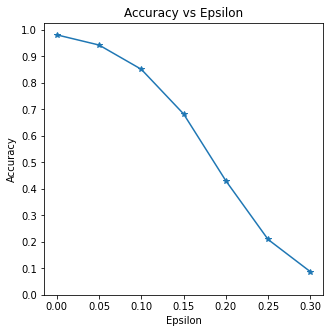

In [9]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### 敵対的サンプルの例

「ノーフリーランチ定理」を覚えていますか？

（日本語訳注：全ての問題において優れた性能を発揮できる“万能”のモデルは存在しないという定理です）

<br>

本チュートリアルの例では、$\epsilon$の値が増加するとテスト精度は低下します。

**ですが**、画像に追加されたノイズの存在にはより気付きやすくなります。

現実には、正解率の低下と気付かれやすさの間にはトレードオフの関係があり、攻撃者はそのトレードオフを考慮する必要があります。



ここでは、$\epsilon$の値ごとに、誤分類させることに成功した敵対的なサンプルの例をいくつか示します。

プロットの各行は異なる$\epsilon$の値を示しています。

最初の行は$\epsilon = 0$の例で、これはノイズがない元の「クリーン」な画像を表現しています。

それぞれの画像のタイトルは、「元の分類」→「攻撃された後の分類結果」を示しています。

<br>

ノイズの追加が分かりやすくなるのは$\epsilon = 0.15$からで、$\epsilon = 0.3$ではかなり明確にノイズが追加されていることがわかります。

とはいえ、**人間の場合には**、この程度のノイズが追加されていたとしても、どの画像に対しても正しいクラス（数字）を識別することができます。

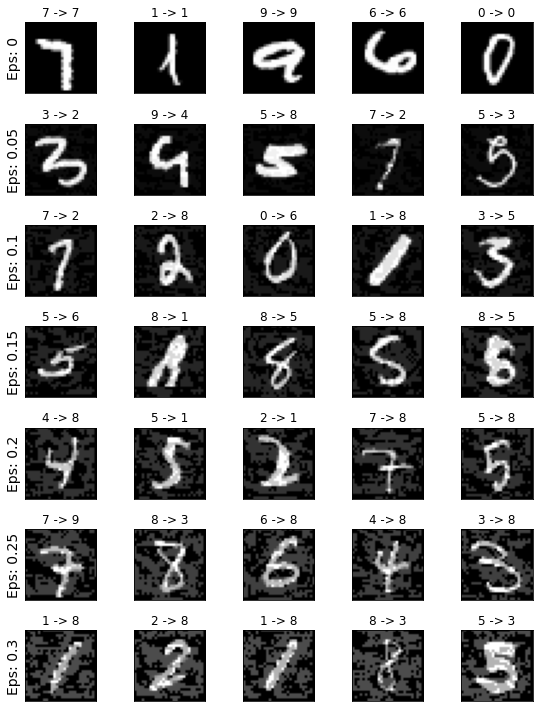

In [10]:
# 各epsilonでの敵対的なサンプルの例をプロットする
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

次のステップ
----------------------

本チュートリアルによって敵対的な機械学習のトピックに関する知見を学んでいただけあなら幸いです。

ここから先に進む際の方向性には、様々な候補があります。




本チュートリアルで扱った攻撃手法は、まさに敵対的攻撃研究の始まりとなった事例です。

この研究以来、機械学習モデルに対して攻撃する方法や、逆に敵対者から機械学習モデルを防御する方法について、その後も多くのアイデアが生まれています。

実際にNIPS2017では、敵対的攻撃と防御のコンペが行われ、そのコンペで使用された手法の多くは、[Adversarial Attacks and Defences Competition](https://arxiv.org/pdf/1804.00097.pdf)という論文に記載され紹介されています。

また、モデルを防御するための試みは、入力に自然にノイズが追加されるケースと、入力が悪意を持って細工されるケースの両方に対し、モデルのロバスト性を高めます。

結果として一般的に、機械学習モデルをロバストにするアイデアへと繋がります。




また、別の方向性として、画像とは異なるデータ形式における敵対的攻撃と防御があります。

敵対的研究は画像分野に限定されたものではありません。

例えばこちら、[音声対テキストモデルに対する攻撃](https://arxiv.org/pdf/1801.01944.pdf)をチェックしてみてください。

そして、敵対的な機械学習についてさらに理解を深めるための（おそらく）最良の方法は、実際に自分で自分のモデルを攻撃してみることです。

NIPS2017の大会で紹介されている、本チュートリアルとは異なる攻撃を実装してみて、FGSMとの違いを確認してみましょう。

そして、自分の攻撃からモデルを防御してみてください。
